In [1]:
import os 

data_dir = '/kaggle/input/biggest-genderface-recognition-dataset/faces'

os.listdir(data_dir)

['man', 'woman']

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input , Dense, GlobalAveragePooling2D, Dropout , Flatten
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
image_size = [224, 224, 3]
Net = EfficientNetV2S(
    include_top = False,
    input_shape = image_size,
    weights = 'imagenet'
)
Net.trainable = False

In [ ]:
x = Flatten()(Net.output)
x = Dense(128, activation = 'relu', kernel_regularizer='l2')(x)
x = Dense(64, activation = 'relu', kernel_regularizer='l2')(x)
x = Dense(32, activation = 'relu', kernel_regularizer='l2')(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = Net.input, outputs = x)

In [ ]:
model.summary()

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input ,
    rotation_range = 40 ,
    width_shift_range = 0.2 ,
    height_shift_range = 0.2 ,
    shear_range = 0.2 ,
    zoom_range = 0.2 ,
    horizontal_flip = True ,
    fill_mode = 'nearest'
)

# Doing similar for the test data also

test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input ,
    rotation_range = 40 ,
    width_shift_range = 0.2 ,
    height_shift_range = 0.2 ,
    shear_range = 0.2 ,
    zoom_range = 0.2 ,
    horizontal_flip = True ,
    fill_mode = 'nearest'
)

In [ ]:
train_path = '/kaggle/input/gender-detection-and-classification-image-dataset/train'
test_path = '/kaggle/input/gender-detection-and-classification-image-dataset/test'

In [ ]:
# train data
train_set = train_datagen.flow_from_directory(train_path,
                                            target_size = ( 224 , 224 ),
                                            batch_size = 32,
                                            class_mode = 'binary')

# test data
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = ( 224 , 224 ),
                                            batch_size = 32,
                                            class_mode = 'binary')

In [ ]:
img = next(train_set)
img[0].shape

In [ ]:
checkpoint = ModelCheckpoint(filepath = '/kaggle/working/effnet.keras' ,monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)
callbacks = [checkpoint, early_stopping]
model_history = model.fit( train_set,
                          validation_data = test_set,
                          epochs = 40,
                          callbacks = callbacks
                        )

In [ ]:
loss, acc = model.evaluate(test_set)
print("Accuracy: {:.2f}".format(acc))
print("Loss: {:.2f}".format(loss))

In [3]:
# Configuração
SIZE = 128
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
# Diretórios dos datasets
data_dir = '/kaggle/input/biggest-genderface-recognition-dataset/faces'
data_test = '/kaggle/input/gender-detection-and-classification-image-dataset'

# Criar datasets de treino e validação
def load_dataset(directory, validation_split=None, subset=None):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=validation_split,
        subset=subset,
        seed=123,
        image_size=(SIZE, SIZE),
        batch_size=BATCH_SIZE)

train_ds = load_dataset(data_dir, validation_split=0.2, subset="training")
val_ds = load_dataset(data_dir, validation_split=0.2, subset="validation")
ds_test = load_dataset(data_test)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 27167 files belonging to 2 classes.
Using 21734 files for training.
Found 27167 files belonging to 2 classes.
Using 5433 files for validation.
Found 300 files belonging to 2 classes.
Classes: ['man', 'woman']


In [5]:
train_size = len(train_ds) * BATCH_SIZE
val_size = len(val_ds) * BATCH_SIZE
test_size = len(ds_test) * BATCH_SIZE

print(f"Tamanho do conjunto de treinamento: {train_size} imagens")
print(f"Tamanho do conjunto de validação: {val_size} imagens")
print(f"Tamanho do conjunto de teste: {test_size} imagens")

num_classes = len(class_names)
print(f"Número de classes: {num_classes}")


Tamanho do conjunto de treinamento: 21744 imagens
Tamanho do conjunto de validação: 5440 imagens
Tamanho do conjunto de teste: 304 imagens
Número de classes: 2


In [6]:
# Balanceamento do dataset
homens, mulheres = [], []
for batch, labels in train_ds:
    for img, label in zip(batch, labels):
        (homens if label == 0 else mulheres).append((img, label))

tamanho_menor_classe = min(len(homens), len(mulheres))
homens_reduzidos = random.sample(homens, tamanho_menor_classe)
balanced_data = homens_reduzidos + mulheres
random.shuffle(balanced_data)

imgs, labels = zip(*balanced_data)
imgs_tensor, labels_tensor = tf.stack(imgs), tf.convert_to_tensor(labels)

balanced_train_ds = tf.data.Dataset.from_tensor_slices((imgs_tensor, labels_tensor))
balanced_train_ds = balanced_train_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Verificando a quantidade de imagens de cada classe antes do balanceamento
print(f"Quantidade de homens antes do balanceamento: {len(homens)}")
print(f"Quantidade de mulheres antes do balanceamento: {len(mulheres)}")

# Quantidade após o balanceamento
print(f"Quantidade de homens após o balanceamento: {len(homens_reduzidos)}")
print(f"Quantidade de mulheres após o balanceamento: {len(mulheres)}")

# Também podemos verificar no dataset final balanceado
balanced_homens = sum(1 for _, label in balanced_data if label == 0)
balanced_mulheres = sum(1 for _, label in balanced_data if label == 1)

print(f"Quantidade de homens no dataset balanceado: {balanced_homens}")
print(f"Quantidade de mulheres no dataset balanceado: {balanced_mulheres}")


Quantidade de homens antes do balanceamento: 14173
Quantidade de mulheres antes do balanceamento: 7561
Quantidade de homens após o balanceamento: 7561
Quantidade de mulheres após o balanceamento: 7561
Quantidade de homens no dataset balanceado: 7561
Quantidade de mulheres no dataset balanceado: 7561


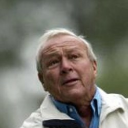

Classe: man


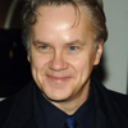

Classe: man


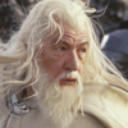

Classe: man


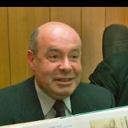

Classe: man


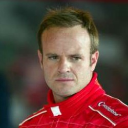

Classe: man


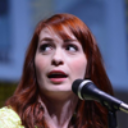

Classe: woman


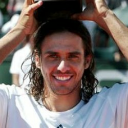

Classe: woman


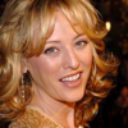

Classe: woman


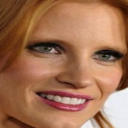

Classe: woman


In [8]:
import cv2
import numpy as np
from IPython.display import display, Image
import random

def plot_images(dataset, class_names):
    # Converter o dataset para uma lista
    images_list = []
    labels_list = []
    
    # Preencher listas com imagens e rótulos
    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    
    # Flatten listas para facilitar a seleção aleatória
    all_images = np.concatenate(images_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)
    
    # Selecionar aleatoriamente 9 imagens
    random_indices = random.sample(range(len(all_images)), 9)
    
    for i in random_indices:
        img = all_images[i].astype("uint8")  # Convertendo a imagem para uint8
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convertendo de RGB para BGR (OpenCV usa BGR)

        # Convertendo a imagem para um formato que o IPython pode exibir
        _, img_encoded = cv2.imencode('.png', img)
        img_display = img_encoded.tobytes()  # Convertendo para bytes

        # Exibindo a imagem com IPython
        display(Image(data=img_display, format='png', width=200))

        # Mostrando o título da classe
        print(f"Classe: {class_names[all_labels[i]]}")

plot_images(balanced_train_ds, class_names)


In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Criar modelo EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3)
)

print(f'Total layers in base model: {len(base_model.layers)}')

# Congelar a base no início
base_model.trainable = False  

inputs = layers.Input(shape=(SIZE, SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.20)(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3))(x)

model = tf.keras.Model(inputs, outputs)

# Compilação inicial
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Definir callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5, 
                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/kaggle/working/best_model.keras', save_best_only=True, monitor='val_loss', mode='min'
)

# Treinamento inicial (apenas cabeçalho do modelo)
history = model.fit(
    balanced_train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[reduce_lr, model_checkpoint]
)

# Fine-Tuning: descongelar parte da base
print("\nFine Tuning\n")
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Treinamento com Fine-Tuning
history_fine = model.fit(
    balanced_train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

# Após o treinamento, salvar o modelo final no formato .h5
model.save('final_model.h5', include_optimizer=False)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers in base model: 238
Epoch 1/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.8144 - auc: 0.8962 - loss: 0.4494 - val_accuracy: 0.8993 - val_auc: 0.9622 - val_loss: 0.2621 - learning_rate: 1.0000e-05
Epoch 2/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8907 - auc: 0.9600 - loss: 0.2695 - val_accuracy: 0.9058 - val_auc: 0.9666 - val_loss: 0.2410 - learning_rate: 1.0000e-05
Epoch 3/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8971 - auc: 0.9641 - loss: 0.2515 - val_accuracy: 0.9107 - val_auc: 0.9685 - val_loss: 0.2317 - learning_rate: 1.0000e-05
Epoch 4/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9021 - auc: 0.9660 - loss: 0.2441 - val_accuracy: 0.9124 - val_auc: 0.9696 - val_loss: 0.2283 - learning_rate: 1.0000e-05
Epoch 5/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9074 - auc: 0.9675 - loss: 0.2384 - val_accuracy: 0.9148 - val_auc: 0.9704 - val_loss: 0.2232 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input , Dense, GlobalAveragePooling2D, Dropout , Flatten
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

# Paths
train_dir = '/kaggle/input/gender-recognition-dataset/Train/Train'
val_dir = '/kaggle/input/gender-recognition-dataset/Test/Test'

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

print(train_generator.class_indices)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

print("oh")

print(train_generator)
images, labels = next(train_generator)
print(labels[:5])
#print(images[1])
#plt.figure(figsize=(2, 2))
#plt.imshow(images[1])
#plt.title(f"Label: {'male' if labels[1] == 1 else 'female'}")
#plt.axis('off')
#plt.show()

print("ah")

# Load EfficientNetB0 without top
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['binary_accuracy'])

print(val_generator)

# Train
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


# Fine-tune (optional)
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=10)

# Save the model
model.save('gender_classification_efficientnet.h5')

In [ ]:
number_of_male = 0
number_of_female = 0
# Predict
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/testmodel/tensorflow2/default/1/gender_classification_efficientnet (2).h5')

# Define the path to the folder of images you want to predict
predict_dir = "/kaggle/input/gender-recognition-dataset/Validation/Validation"

# Class labels
labels = ['female', 'male']

# Function to preprocess a single image
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)                           # Load BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)           # Convert to RGB
    img = cv2.resize(img, target_size)                   # Resize
    img = img.astype('float32') / 255.0                  # Normalize (match training)
    return img

# Load and preprocess all images
image_paths = [os.path.join(predict_dir, fname) for fname in os.listdir(predict_dir)
               if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

images = [preprocess_image(path) for path in image_paths]
images_array = np.array(images)

# Predict
predictions = model.predict(images_array)

# Print results
for path, pred in zip(image_paths, predictions):
    global number_of_male, number_of_female # Declare global variables to modify them
    #print(pred)
    prediction = pred
    gender = 'Female' if prediction < 0.5 else 'Male'
    confidence = prediction if prediction < 0.5 else 1 - prediction
    if( prediction < 0.5):
      number_of_female += 1
    else:
      number_of_male += 1
    #print(f"Predicted Gender: {gender} (Confidence: {confidence:.2f})")
    #label = labels[int(pred > 0.5)]
    #print(f"{os.path.basename(path)} → {label} ({pred[0]:.2f})")
print(f"Number of male: {number_of_male}")
print(f"Number of female: {number_of_female}")

340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9192 - auc_1: 0.9747 - loss: 0.2123
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 715ms/step - accuracy: 0.5673 - auc_1: 0.5512 - loss: 1.1339
Validação - Perda: 0.2154931277036667, Acurácia: 0.9149640798568726, AUC: 0.9742444157600403
Teste - Perda: 1.3060600757598877, Acurácia: 0.5066666603088379, AUC: 0.4644318222999573
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


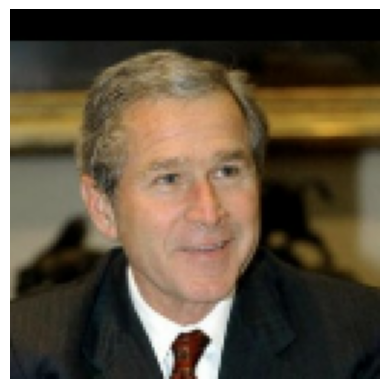

Previsão: Man (Probabilidade: 0.0001)
Rótulo verdadeiro: man


In [10]:
# Avaliação
val_results = model.evaluate(val_ds)
test_results = model.evaluate(ds_test)

print(f"Validação - Perda: {val_results[0]}, Acurácia: {val_results[1]}, AUC: {val_results[2]}")
print(f"Teste - Perda: {test_results[0]}, Acurácia: {test_results[1]}, AUC: {test_results[2]}")

# Teste de previsão
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_sample(model, dataset, class_names):
    for image_batch, labels_batch in dataset.take(1):
        test_image = image_batch[0]
        test_label = labels_batch[0]
    
    test_image = preprocess_input(test_image)  # Correção na normalização
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image)
    
    predicted_class = "Woman" if prediction >= 0.5 else "Man"
    true_class = class_names[int(test_label)]  # Correção na classe verdadeira
    
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # Exibir imagem corretamente
    plt.axis('off')
    plt.show()
    
    print(f"Previsão: {predicted_class} (Probabilidade: {prediction[0][0]:.4f})")
    print(f"Rótulo verdadeiro: {true_class}")

predict_sample(model, train_ds, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


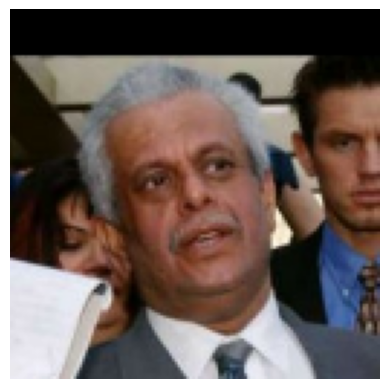

Previsão: Man (Probabilidade: 0.0050)
Rótulo verdadeiro: man


In [11]:
predict_sample(model, train_ds, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


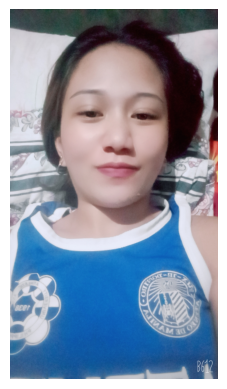

Previsão: Woman (Probabilidade: 0.8880)


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image

# 📌 Carregar o modelo treinado
model = tf.keras.models.load_model("/kaggle/working/best_model.keras")

# 📌 Função para carregar e pré-processar a imagem
def preprocess_image(image_path, target_size=(SIZE, SIZE)):
    image = Image.open(image_path)  # Abrir imagem
    image = image.resize(target_size)  # Redimensionar
    image = np.array(image)  # Converter para array
    image = preprocess_input(image)  # Aplicar pré-processamento do EfficientNet
    image = np.expand_dims(image, axis=0)  # Adicionar batch dimension
    return image

# 📌 Caminho da imagem que você quer testar
#image_path = "/kaggle/input/gender-detection-and-classification-image-dataset/test/men/112.jpg"
image_path = '/kaggle/input/gender-detection-and-classification-image-dataset/test/women/125.jpg'

# 📌 Carregar e processar a imagem
image = preprocess_image(image_path)

# 📌 Fazer a previsão
prediction = model.predict(image)

# 📌 Determinar a classe prevista
predicted_class = "Woman" if prediction >= 0.5 else "Man"

# 📌 Exibir a imagem e o resultado
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

print(f"Previsão: {predicted_class} (Probabilidade: {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


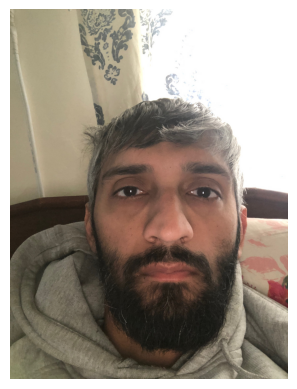

Previsão: Man (Probabilidade: 0.0122)


In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image

# 📌 Carregar o modelo treinado
model = tf.keras.models.load_model("/kaggle/working/best_model.keras")

# 📌 Função para carregar e pré-processar a imagem
def preprocess_image(image_path, target_size=(SIZE, SIZE)):
    image = Image.open(image_path)  # Abrir imagem
    image = image.resize(target_size)  # Redimensionar
    image = np.array(image)  # Converter para array
    image = preprocess_input(image)  # Aplicar pré-processamento do EfficientNet
    image = np.expand_dims(image, axis=0)  # Adicionar batch dimension
    return image

# 📌 Caminho da imagem que você quer testar
image_path = "/kaggle/input/gender-detection-and-classification-image-dataset/test/men/120.jpg"
#image_path = '/kaggle/input/gender-detection-and-classification-image-dataset/test/women/139.jpg'

# 📌 Carregar e processar a imagem
image = preprocess_image(image_path)

# 📌 Fazer a previsão
prediction = model.predict(image)

# 📌 Determinar a classe prevista
predicted_class = "Woman" if prediction >= 0.5 else "Man"

# 📌 Exibir a imagem e o resultado
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

print(f"Previsão: {predicted_class} (Probabilidade: {prediction[0][0]:.4f})")


In [14]:
import keras 
model_path  = '/kaggle/working/final_model.h5'
model_test = keras.models.load_model(model_path, compile=False)
model_test.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,362,340 (20.46 MB)

 Trainable params: 2,808,929 (10.72 MB)

 Non-trainable params: 2,553,411 (9.74 MB)